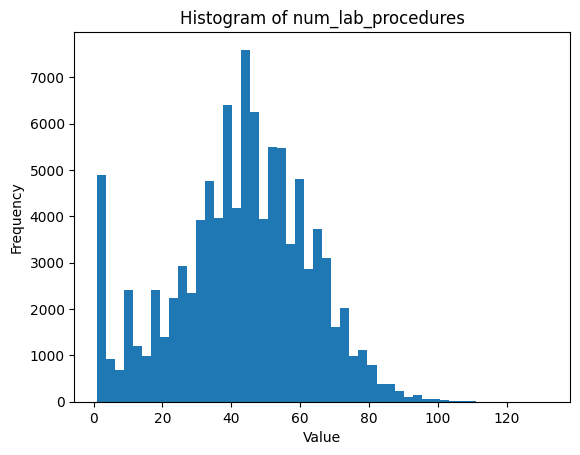

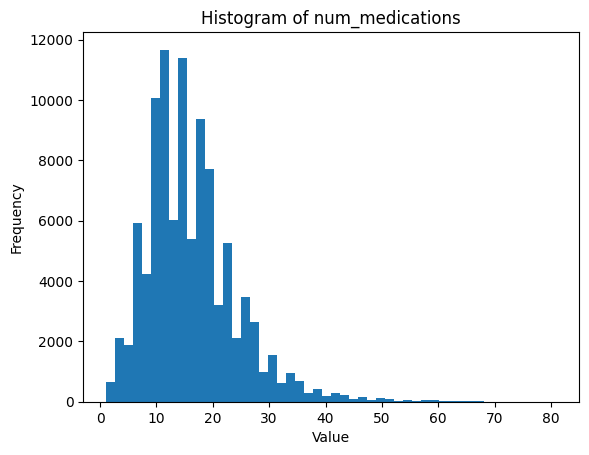

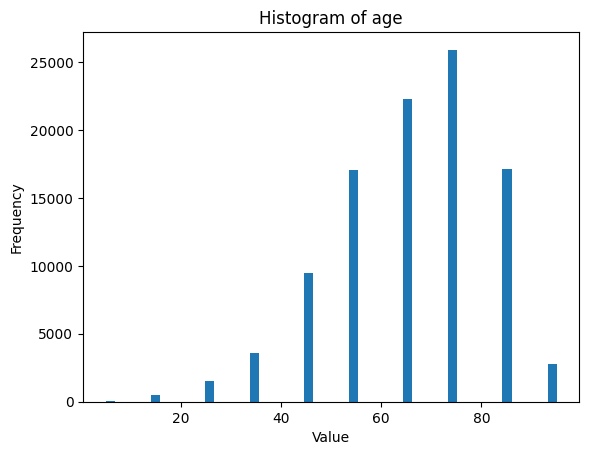

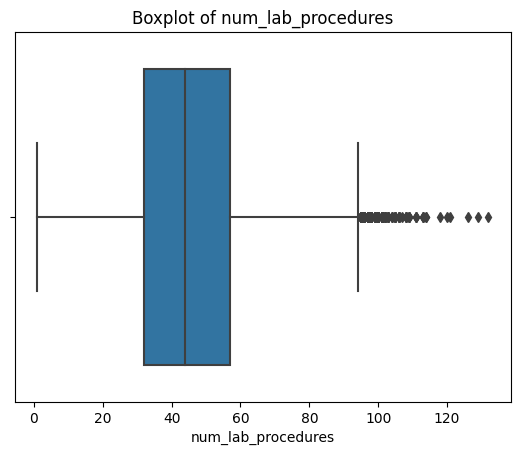

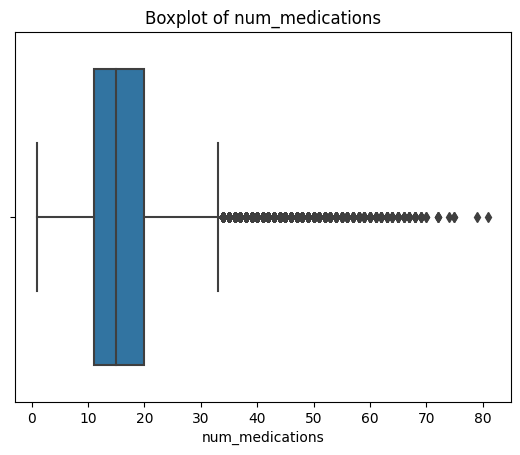

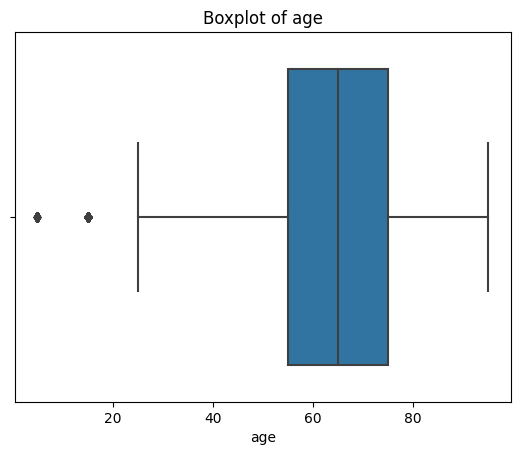

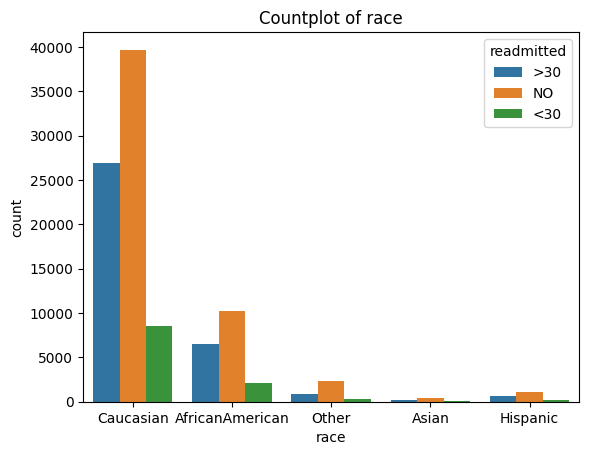

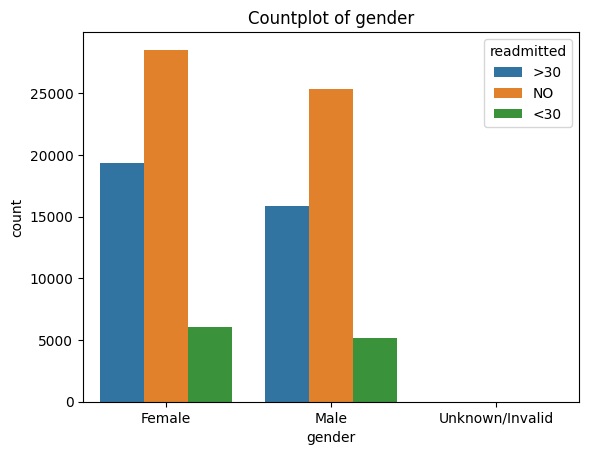

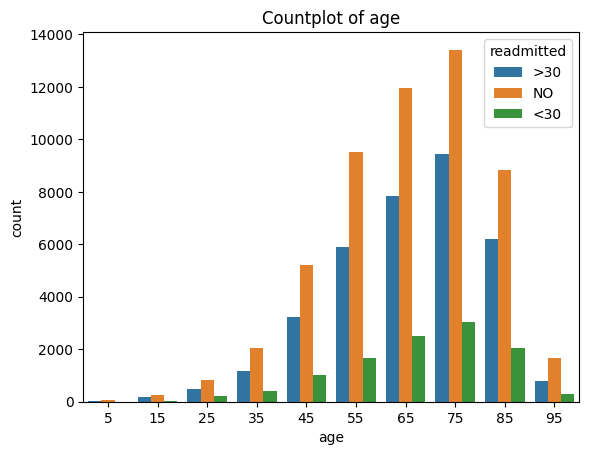

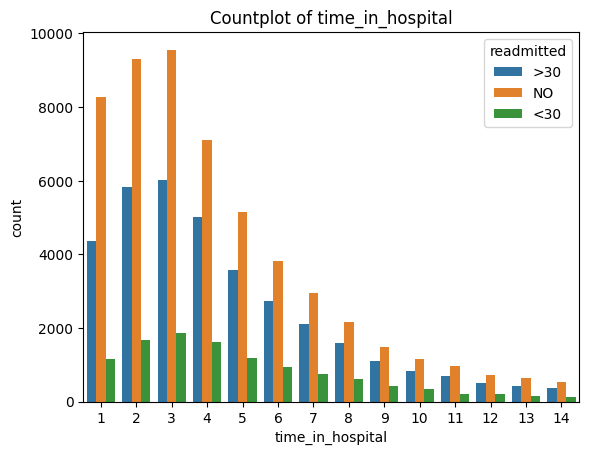

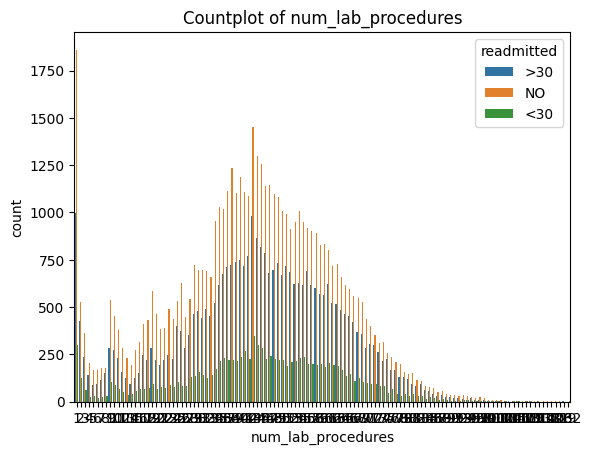

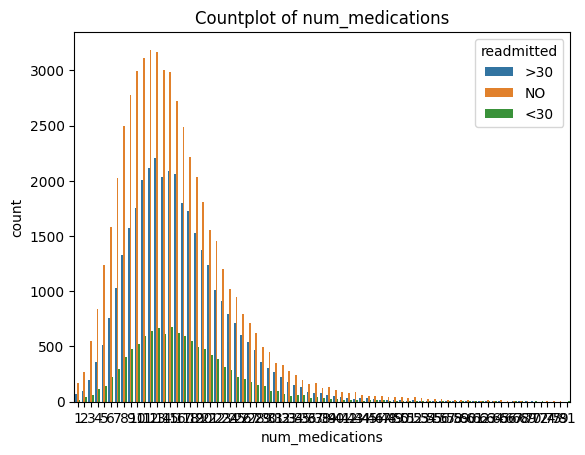

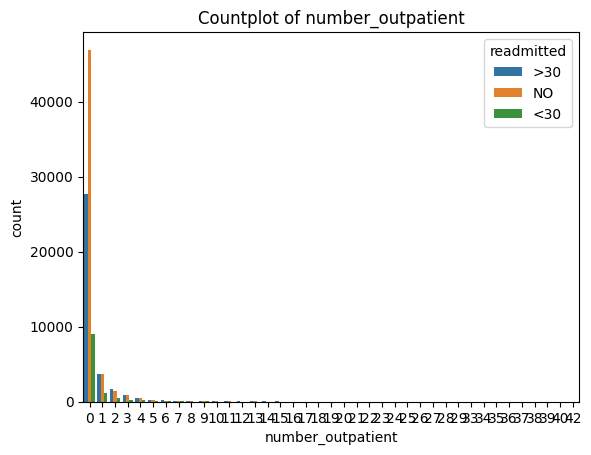

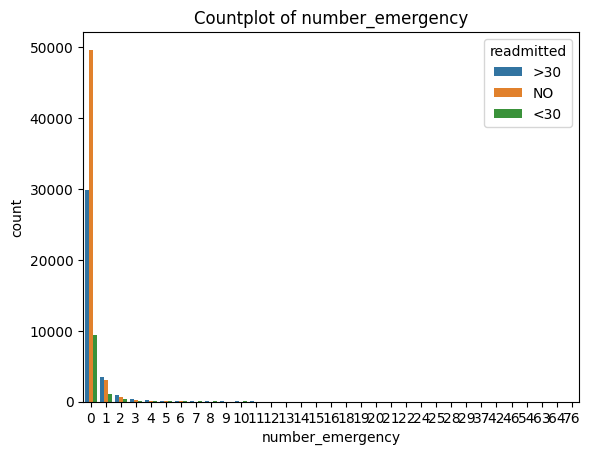

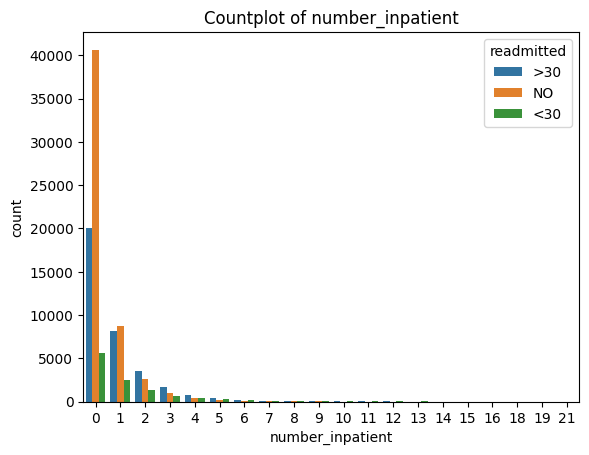

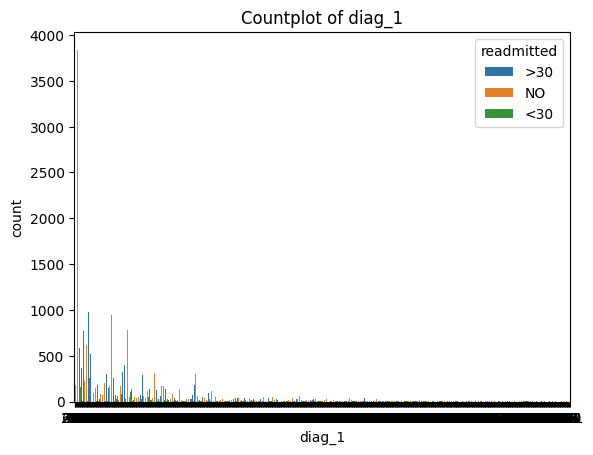

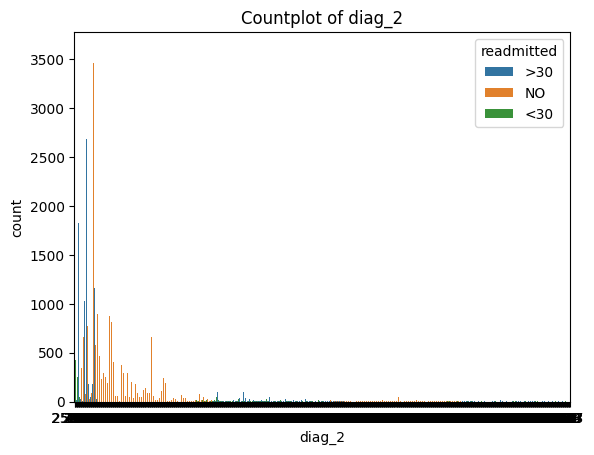

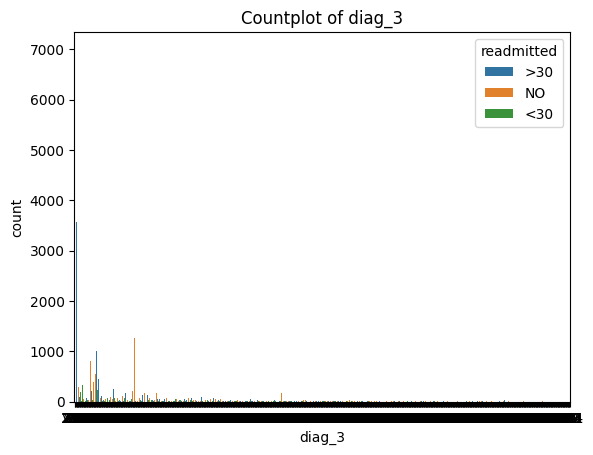

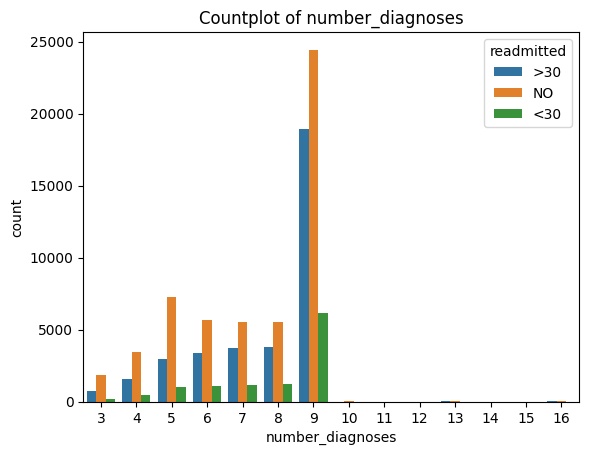

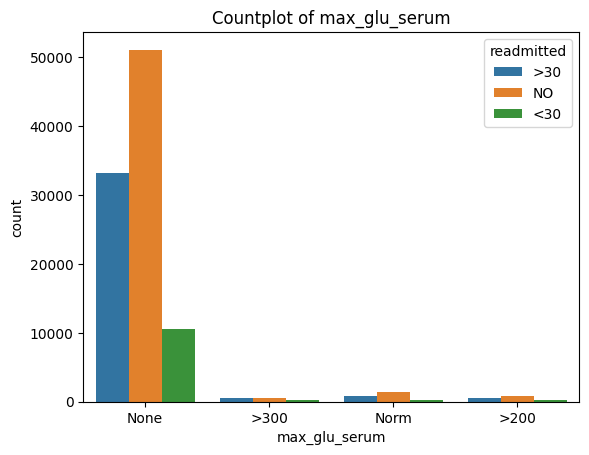

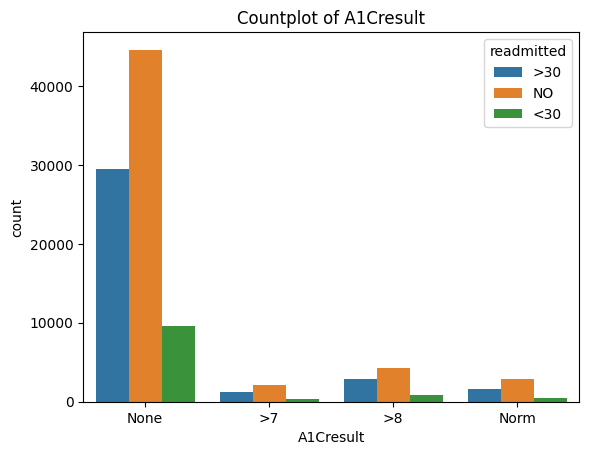

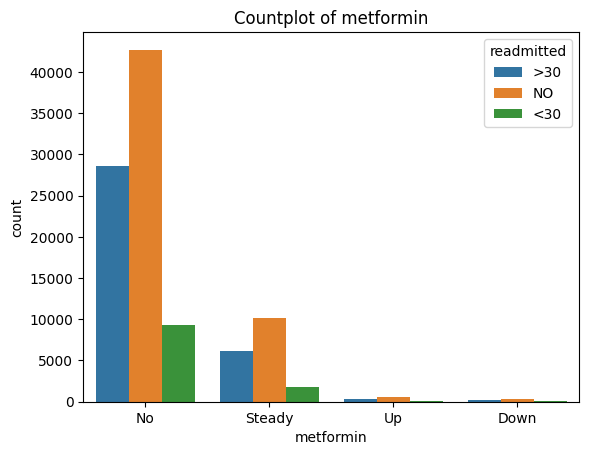

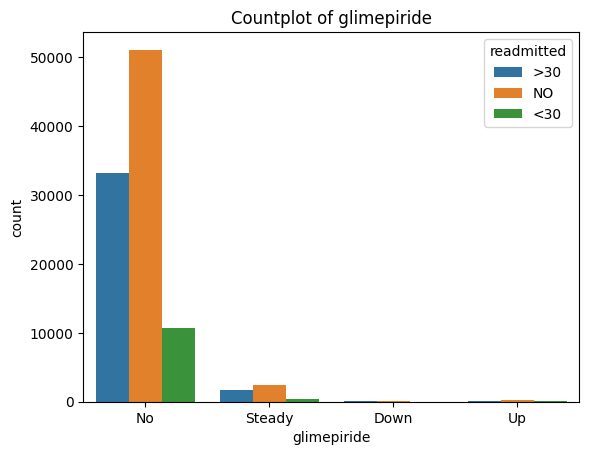

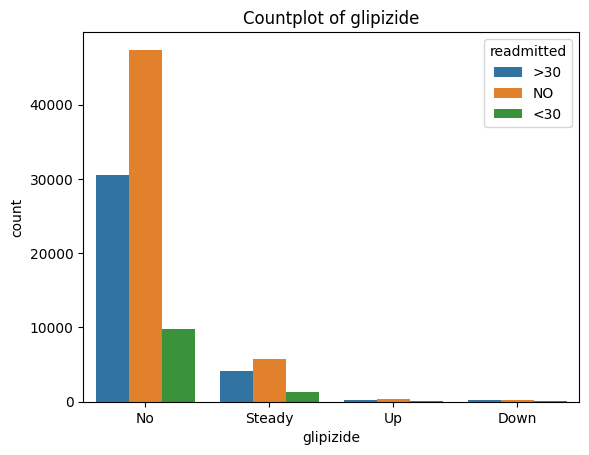

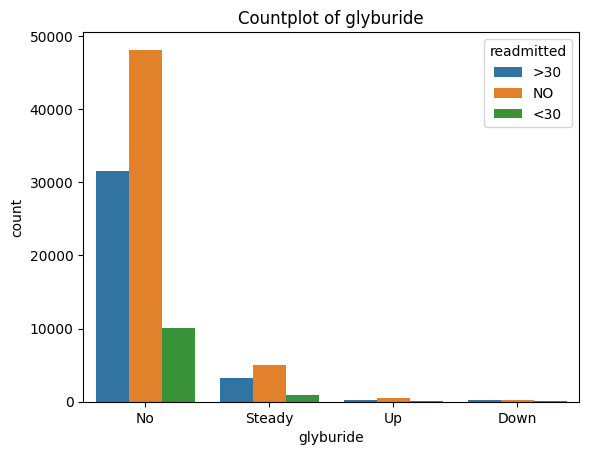

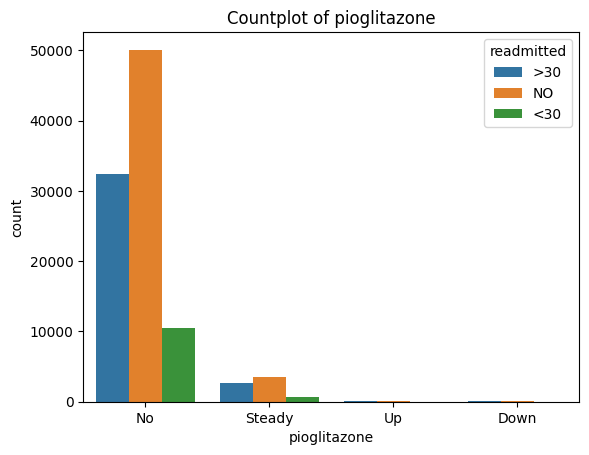

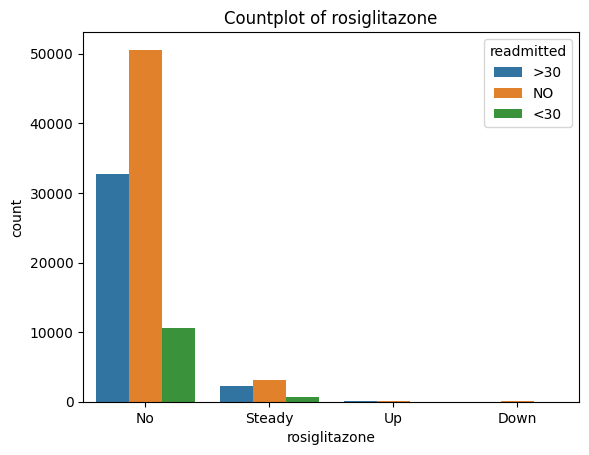

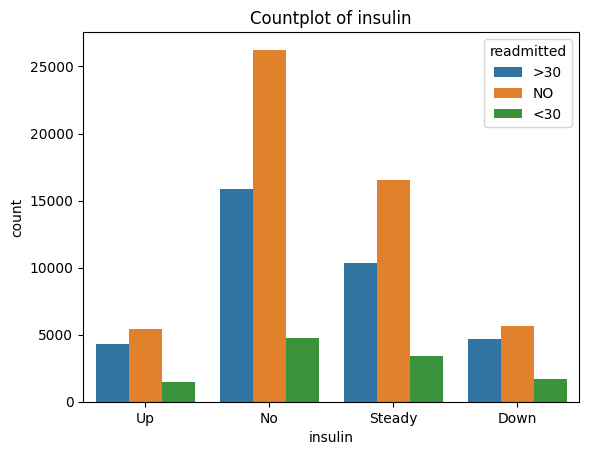

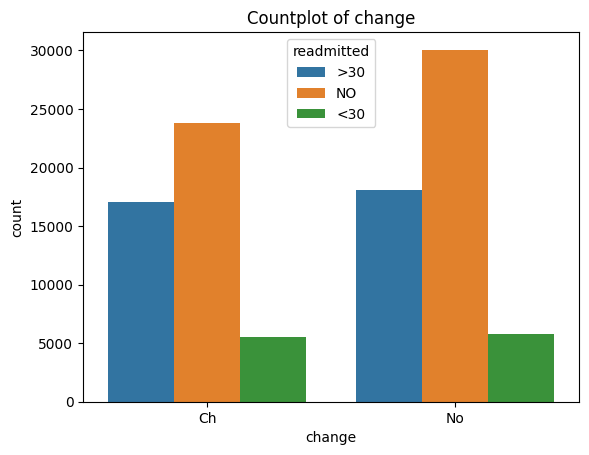

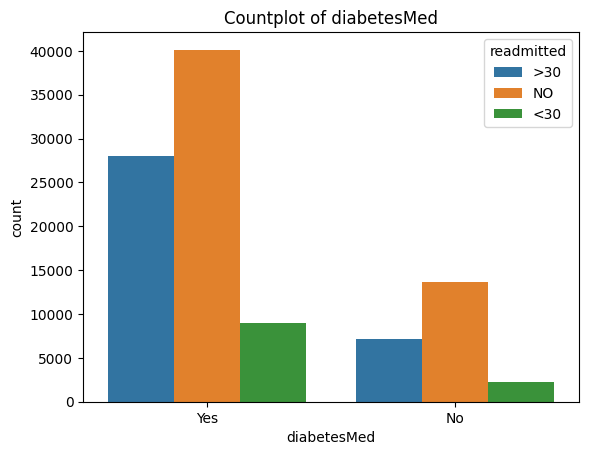

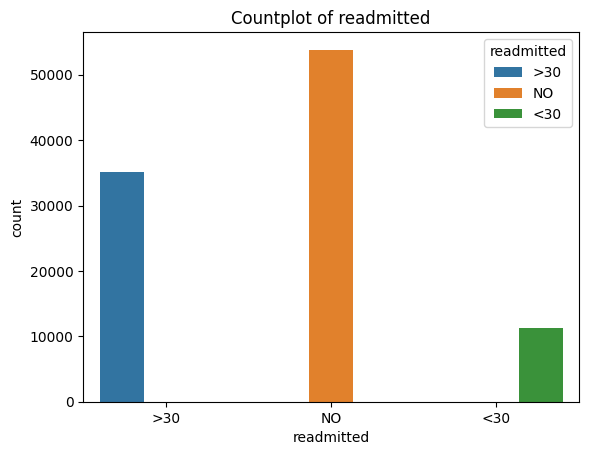

Logistic Regression Accuracy: 0.5992956146330379
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1558
           1       0.44      0.13      0.20      5481
           2       0.62      0.93      0.74     10565

    accuracy                           0.60     17604
   macro avg       0.35      0.35      0.31     17604
weighted avg       0.51      0.60      0.51     17604



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


XGBoost Accuracy: 0.631163371960918
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.03      0.06      1558
           1       0.51      0.36      0.42      5481
           2       0.67      0.86      0.75     10565

    accuracy                           0.63     17604
   macro avg       0.52      0.42      0.41     17604
weighted avg       0.59      0.63      0.59     17604



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

# Load the dataset
df = pd.read_excel('Copy of diabetes_data.xlsx')

# Data preprocessing
df.replace('?', np.nan, inplace=True)
df.drop(['weight', 'payer_code', 'medical_specialty'], axis=1, inplace=True)
df['race'] = df.groupby('patient_nbr')['race'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 'Other'))
df.dropna(inplace=True)
age_map = {'[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, '[40-50)': 45,
           '[50-60)': 55, '[60-70)': 65, '[70-80)': 75, '[80-90)': 85, '[90-100)': 95}
df['age'] = df['age'].map(age_map)

# Data visualization
numerical_cols = ['num_lab_procedures', 'num_medications', 'age']
for col in numerical_cols:
    plt.hist(df[col], bins=50)
    plt.title(f"Histogram of {col}")
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

# Data type conversion and outlier removal
num_cols = ['age', 'time_in_hospital', 'num_lab_procedures', 'num_medications',
            'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']
df[num_cols] = df[num_cols].astype('object')
for col in numerical_cols:
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

# Low variance column removal
low_variance_cols = [col for col in df.columns if df[col].value_counts(normalize=True).iloc[0] > 0.95]
df.drop(columns=low_variance_cols, inplace=True)

# Categorical data visualization
categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
for col in categorical_columns:
    sns.countplot(x=col, hue='readmitted', data=df)
    plt.title(f'Countplot of {col}')
    plt.show()

# Data cleaning and filtering
df = df[~df.duplicated(subset=['patient_nbr', 'gender'])]
df = df[df['gender'] != 'Unknown/Invalid']

# ICD-9 Code categorization
def categorize_icd9_code(icd_code):
    try:
        icd_code = float(icd_code)
        # Categorize ICD-9 codes based on ranges
        # ...

    except:
        return "external causes or supplemental"

df['diag_1'] = df['diag_1'].apply(categorize_icd9_code)
df['diag_2'] = df['diag_2'].apply(categorize_icd9_code)
df['diag_3'] = df['diag_3'].apply(categorize_icd9_code)

# Medication data processing
med_cols = ['metformin', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin']
df[med_cols] = df[med_cols].applymap(lambda x: 1 if x != 'No' else 0)
df['A1Cresult'] = df['A1Cresult'].map({'None': -99, '>8': 1, 'Norm': 0, '>7': 1})
df['max_glu_serum'] = df['max_glu_serum'].map({'None': -99, '>200': 1, 'Norm': 0, '>300': 1})
df['change'] = df['change'].map({'Ch': 1, 'No': 0})
df['diabetesMed'] = df['diabetesMed'].map({'Yes': 1, 'No': 0})

# Label encoding
label_encoder = LabelEncoder()
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])

# Splitting and standardization
X = df.drop('readmitted', axis=1)
y = df['readmitted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
sc = StandardScaler()
X_train[num_cols] = sc.fit_transform(X_train[num_cols])
X_test[num_cols] = sc.transform(X_test[num_cols])

# Logistic Regression model
lg_model = LogisticRegression(multi_class='auto', solver='lbfgs')
lg_model.fit(X_train, y_train)
y_pred = lg_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy}")
print(f"Logistic Regression Classification Report:\n{classification_report(y_test, y_pred)}")

# XGBoost model
model = xgb.XGBClassifier(objective='multi:softprob', num_class=3)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Accuracy: {accuracy}")
print(f"XGBoost Classification Report:\n{classification_report(y_test, y_pred)}")